In [1]:
import tensorflow as tf
import numpy as np
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, make_confusion_matrix
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

C:\Users\shrih\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\shrih\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\shrih\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
train_dir = "Data/101_food_classes_10_percent/train/"
test_dir = "Data/101_food_classes_10_percent/test/"

In [3]:
# How many images/classes are there?
walk_through_dir("Data/101_food_classes_10_percent")

There are 2 directories and 0 images in 'Data/101_food_classes_10_percent'.
There are 101 directories and 0 images in 'Data/101_food_classes_10_percent\test'.
There are 0 directories and 250 images in 'Data/101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in 'Data/101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in 'Data/101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in 'Data/101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in 'Data/101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in 'Data/101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in 'Data/101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in 'Data/101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in 'Data/101_food_classes_10_percent\test\bread_

In [4]:
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode="categorical",
                                                                               image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE,
                                                               shuffle=False) # Don't shuffle test data for prediction analysis


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


### Train a big dog model with Tranfer learning with 10 percent of 101 fodd classes

Here are the steps we're going to take:
- Create a ModelCheckpoint callback
- Create a data augmentation layer to build data augmentation right into the model
- Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
- Compile our model
- Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [5]:
# Create a checkpoint callback
checkpoint_path = "tansfer_learning/Scaling_up/101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [6]:
# Setup data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
], name = "data_augmentation")

In [7]:
# Stepup the base model and freeze it's layers (this will extract features)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False # Freeze all the patterns it has learned

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [8]:
# Get a summary of model 
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [9]:
# Compile
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

# Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                          epochs=5,
                                          validation_data=test_data,
                                          validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5


237/237 [==============================] - 236s 969ms/step - loss: 3.3680 - accuracy: 0.2680 - val_loss: 2.5404 - val_accuracy: 0.4359
Epoch 2/5
237/237 [==============================] - 222s 938ms/step - loss: 2.1900 - accuracy: 0.5017 - val_loss: 2.0726 - val_accuracy: 0.5013
Epoch 3/5
237/237 [==============================] - 243s 1s/step - loss: 1.8228 - accuracy: 0.5599 - val_loss: 1.9194 - val_accuracy: 0.5254
Epoch 4/5
237/237 [==============================] - 243s 1s/step - loss: 1.6148 - accuracy: 0.6070 - val_loss: 1.7970 - val_accuracy: 0.5416
Epoch 5/5
237/237 [==============================] - 240s 1s/step - loss: 1.4531 - accuracy: 0.6446 - val_loss: 1.7909 - val_accuracy: 0.5323


In [10]:
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 483s 612ms/step - loss: 1.5819 - accuracy: 0.5833


[1.581947684288025, 0.5832871198654175]

## Make predictions with our trained model

In [11]:
# Make predictions 
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 456s 575ms/step


In [12]:
len(test_data)

790

In [13]:
# How many predictions are there
len(preds_probs)

25250

In [14]:
# What's the shape of our predictons?
preds_probs.shape

(25250, 101)

In [15]:
# Let's see what the forst 10 predictions look like
preds_probs[:10]

array([[6.2104456e-02, 1.2120759e-03, 1.3769598e-01, ..., 2.7639783e-04,
        8.1937583e-03, 7.0202509e-03],
       [8.6982232e-01, 3.2270539e-06, 1.8517491e-03, ..., 5.5863638e-03,
        2.3457619e-06, 4.6530171e-05],
       [1.5449472e-01, 6.9387662e-03, 4.7669668e-02, ..., 1.8481667e-03,
        1.3119382e-03, 2.4830778e-03],
       ...,
       [1.1871353e-01, 8.7788867e-05, 6.0940902e-03, ..., 5.6369927e-02,
        9.3671551e-04, 4.7923299e-04],
       [1.4021416e-01, 1.6708798e-03, 2.5149634e-01, ..., 1.2465190e-03,
        7.1958086e-04, 5.2645552e-04],
       [3.6157215e-01, 2.4807319e-05, 8.8980794e-03, ..., 5.8888062e-03,
        7.1719682e-05, 1.2057829e-03]], dtype=float32)

In [16]:
# What does the first prediction probability look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([6.21044561e-02, 1.21207593e-03, 1.37695983e-01, 7.28285522e-06,
        1.09701934e-04, 5.08606172e-05, 9.65703919e-04, 4.61846357e-05,
        2.52225585e-02, 3.36381653e-03, 1.65547302e-04, 1.23176345e-04,
        6.24140073e-03, 9.34676063e-06, 1.77219938e-02, 1.86741189e-03,
        5.95702382e-04, 8.90890136e-03, 3.41223343e-03, 2.00280847e-04,
        2.09708349e-03, 8.26102114e-05, 3.25061643e-04, 3.85065970e-04,
        5.63313544e-04, 9.23702214e-03, 4.54277499e-03, 3.49967391e-04,
        1.26608357e-01, 3.28872818e-03, 7.91143393e-05, 3.05853994e-03,
        6.26713212e-04, 7.10532695e-05, 1.20534692e-02, 1.23657854e-04,
        2.75452179e-03, 3.39134084e-03, 4.76261079e-02, 3.18358332e-04,
        1.49452675e-03, 4.84087644e-03, 1.00530591e-03, 4.85834535e-05,
        9.01033403e-04, 1.58477400e-04, 5.23711648e-03, 2.46026233e-04,
        8.60459550e-05, 6.49064556e-02, 1.13459304e-03, 3.94196104e-04,
        3.89522500e-02, 8.75091851e-02, 1.46463062e-04, 4.589762

In [17]:
print(f"Number of prediction probabilities for sample: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 look like:\n {preds_probs[0]}")
print(f"The class with the highest probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample: 101
What prediction probability sample 0 look like:
 [6.21044561e-02 1.21207593e-03 1.37695983e-01 7.28285522e-06
 1.09701934e-04 5.08606172e-05 9.65703919e-04 4.61846357e-05
 2.52225585e-02 3.36381653e-03 1.65547302e-04 1.23176345e-04
 6.24140073e-03 9.34676063e-06 1.77219938e-02 1.86741189e-03
 5.95702382e-04 8.90890136e-03 3.41223343e-03 2.00280847e-04
 2.09708349e-03 8.26102114e-05 3.25061643e-04 3.85065970e-04
 5.63313544e-04 9.23702214e-03 4.54277499e-03 3.49967391e-04
 1.26608357e-01 3.28872818e-03 7.91143393e-05 3.05853994e-03
 6.26713212e-04 7.10532695e-05 1.20534692e-02 1.23657854e-04
 2.75452179e-03 3.39134084e-03 4.76261079e-02 3.18358332e-04
 1.49452675e-03 4.84087644e-03 1.00530591e-03 4.85834535e-05
 9.01033403e-04 1.58477400e-04 5.23711648e-03 2.46026233e-04
 8.60459550e-05 6.49064556e-02 1.13459304e-03 3.94196104e-04
 3.89522500e-02 8.75091851e-02 1.46463062e-04 4.58976217e-02
 3.53953503e-02 8.58913269e-03 4.82781883e-03 

In [18]:
test_data.class_names[2]

'baklava'

In [19]:
# Gwet the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

#How do they look?
pred_classes[:10]

array([ 2,  0,  0, 38,  8, 78, 29, 62,  2,  0], dtype=int64)

In [20]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original dataset labels

In [21]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0,0,0,1....0,0], we want the index value where the "1" occurs
y_labels[:10] # look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [22]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating our model's predictions

One way to check that our model'spredictions array is in the same order as our test labels array is to find the accuracy score

In [23]:
results_downloaded_model

[1.581947684288025, 0.5832871198654175]

In [24]:
# Let's try scikit-learn's accuracy score functiond and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                 y_pred = pred_classes)
sklearn_accuracy

0.5832871287128713

In [25]:
# Does this metrics come clos to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

# Let's get visual: Making aa confusion matrix

In [26]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [27]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ## Changed (plot x-labels vertically) ##
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [28]:
make_confusion_matrix(y_true = y_labels,
                     y_pred = pred_classes,
                     classes=class_names,
                     figsize=(100,100),
                     text_size=25,
                     savefig=True)

## Let's keep the evaluation train going, time for a claassification report

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                           y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.38      0.18      0.24       250
           1       0.49      0.73      0.59       250
           2       0.56      0.64      0.59       250
           3       0.80      0.52      0.63       250
           4       0.53      0.35      0.42       250
           5       0.49      0.34      0.40       250
           6       0.71      0.81      0.76       250
           7       0.83      0.72      0.78       250
           8       0.27      0.54      0.36       250
           9       0.41      0.65      0.50       250
          10       0.46      0.41      0.44       250
          11       0.72      0.52      0.61       250
          12       0.73      0.58      0.64       250
          13       0.60      0.51      0.55       250
          14       0.57      0.51      0.54       250
          15       0.47      0.27      0.34       250
          16       0.57      0.64      0.61       250
          17       0.33    

In [30]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.37606837606837606,
  'recall': 0.176,
  'f1-score': 0.23978201634877383,
  'support': 250.0},
 '1': {'precision': 0.4918918918918919,
  'recall': 0.728,
  'f1-score': 0.5870967741935484,
  'support': 250.0},
 '2': {'precision': 0.5559440559440559,
  'recall': 0.636,
  'f1-score': 0.5932835820895522,
  'support': 250.0},
 '3': {'precision': 0.7987804878048781,
  'recall': 0.524,
  'f1-score': 0.6328502415458938,
  'support': 250.0},
 '4': {'precision': 0.5337423312883436,
  'recall': 0.348,
  'f1-score': 0.4213075060532688,
  'support': 250.0},
 '5': {'precision': 0.49411764705882355,
  'recall': 0.336,
  'f1-score': 0.4,
  'support': 250.0},
 '6': {'precision': 0.7073170731707317,
  'recall': 0.812,
  'f1-score': 0.7560521415270018,
  'support': 250.0},
 '7': {'precision': 0.8341013824884793,
  'recall': 0.724,
  'f1-score': 0.7751605995717344,
  'support': 250.0},
 '8': {'precision': 0.2701612903225806,
  'recall': 0.536,
  'f1-score': 0.35924932975871315,
  'sup

# Let's plot all our classes F-1 scores

In [31]:
# create emptydictionary
class_f1_scores = {}
#Loop through classification report dictionary items
for k, v in classification_report_dict.items():
    if k == "accuracy":# stop once we get to accuracy key
        break
    else:
        # Add class names and f1-scores to new dicitonary
        class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.23978201634877383,
 'baby_back_ribs': 0.5870967741935484,
 'baklava': 0.5932835820895522,
 'beef_carpaccio': 0.6328502415458938,
 'beef_tartare': 0.4213075060532688,
 'beet_salad': 0.4,
 'beignets': 0.7560521415270018,
 'bibimbap': 0.7751605995717344,
 'bread_pudding': 0.35924932975871315,
 'breakfast_burrito': 0.5023255813953488,
 'bruschetta': 0.43644067796610164,
 'caesar_salad': 0.6064814814814814,
 'cannoli': 0.6442953020134227,
 'caprese_salad': 0.5517241379310344,
 'carrot_cake': 0.5412262156448204,
 'ceviche': 0.34430379746835443,
 'cheese_plate': 0.6052631578947368,
 'cheesecake': 0.388704318936877,
 'chicken_curry': 0.4849785407725322,
 'chicken_quesadilla': 0.6457925636007827,
 'chicken_wings': 0.7251461988304094,
 'chocolate_cake': 0.5257142857142857,
 'chocolate_mousse': 0.37575757575757573,
 'churros': 0.7101123595505618,
 'clam_chowder': 0.7225548902195608,
 'club_sandwich': 0.6288032454361056,
 'crab_cakes': 0.36483516483516487,
 'creme_brulee': 0.737254

In [32]:
# Turn f1-scores into dataframe
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                         "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [33]:
f1_scores[:10]

class_names  f1-score
33        edamame  0.960938
63       macarons  0.866808
45  frozen_yogurt  0.843177
32      dumplings  0.841897
69        oysters  0.830022
86        sashimi  0.828000
65        mussels  0.806034
64      miso_soup  0.803636
75            pho  0.803571
68    onion_rings  0.802372

In [34]:
f1_scores[-10:]

class_names  f1-score
50    grilled_salmon  0.345361
15           ceviche  0.344304
56  huevos_rancheros  0.330523
99      tuna_tartare  0.329621
82           ravioli  0.294976
66            nachos  0.284790
93             steak  0.282306
77         pork_chop  0.260204
39         foie_gras  0.243750
0          apple_pie  0.239782

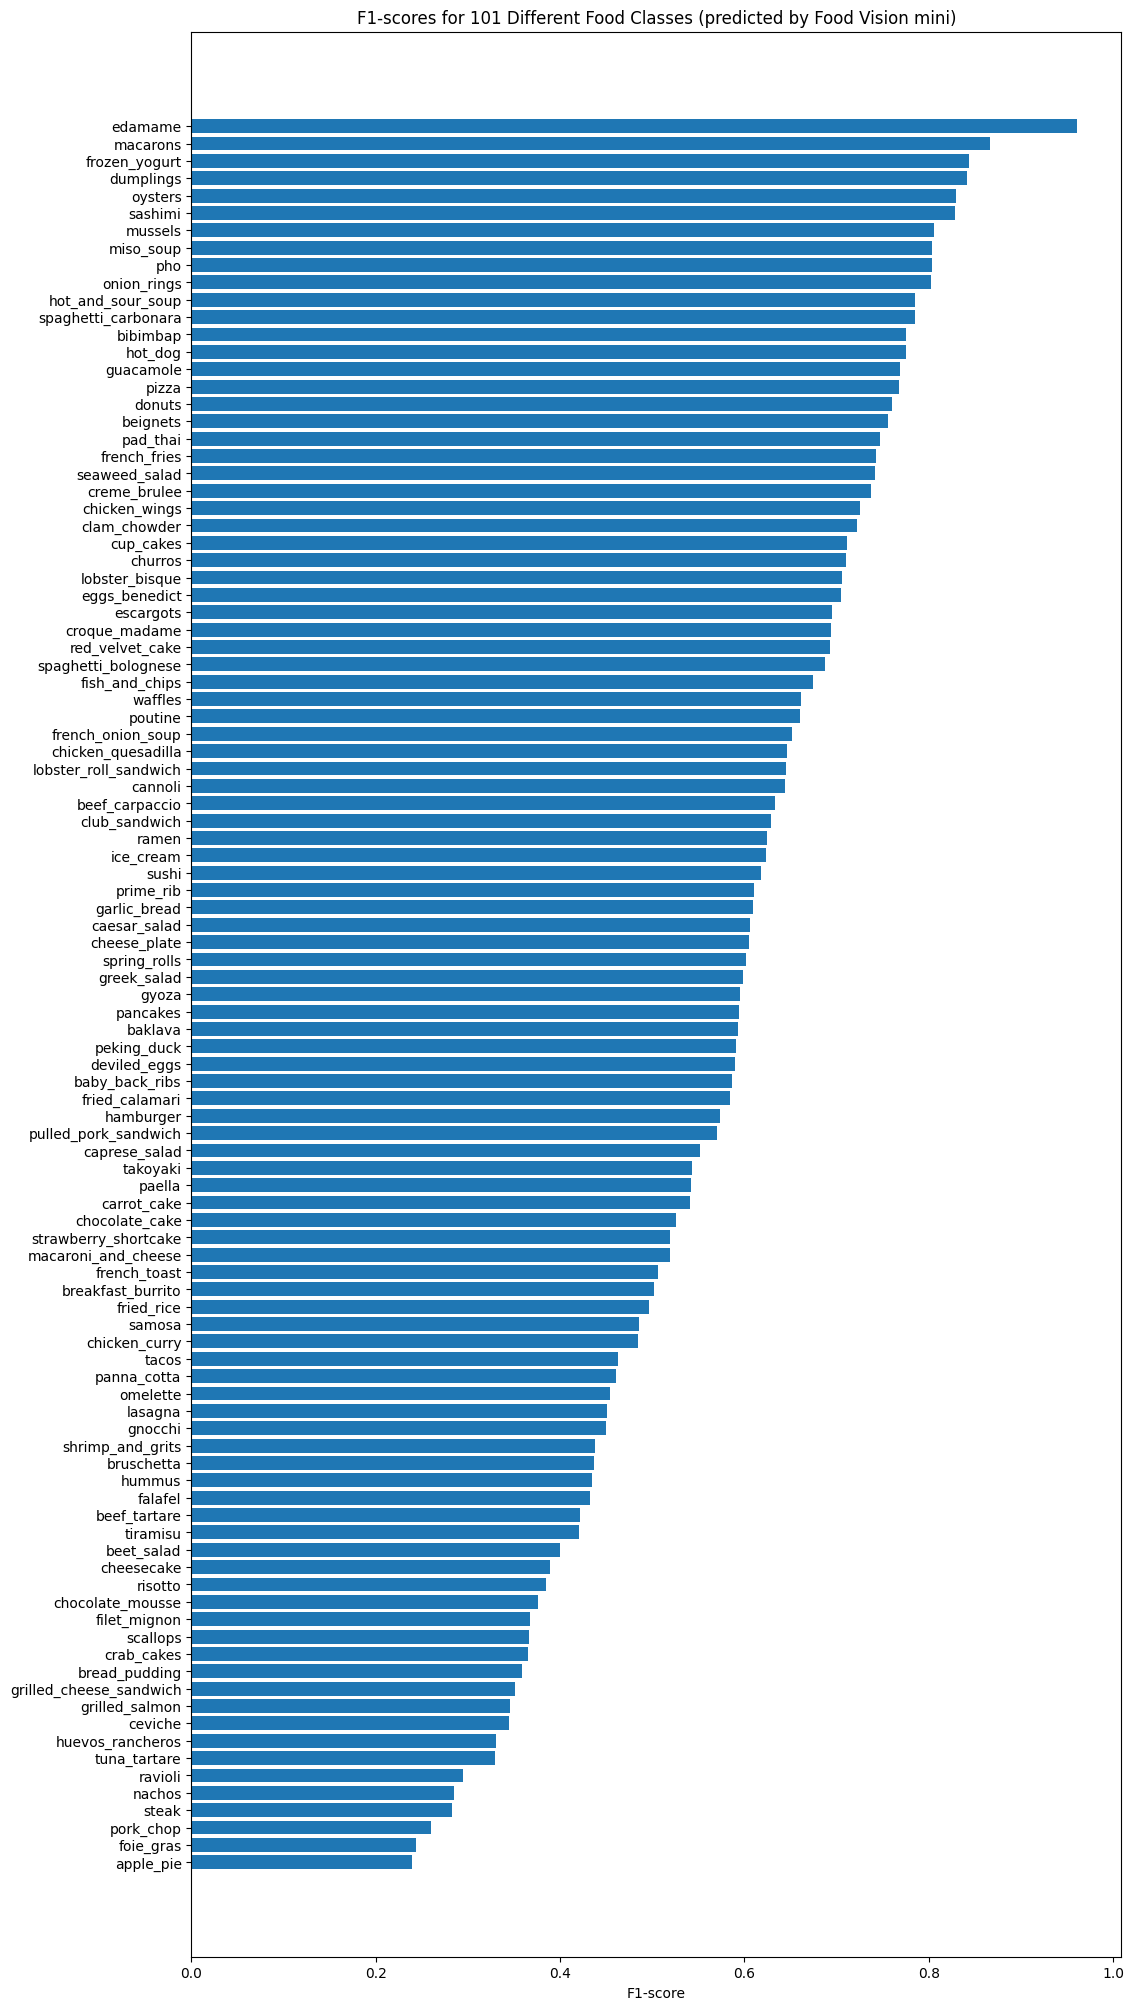

In [35]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-scores values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"]);
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision mini)")
ax.invert_yaxis(); # reverse the order of our plor

## Visualizing predictions on Test images

To visualize our model's predictions on our own images, we'll need to load and preprocess images, specifically it will need to:
* Read in a target image filepath using tf.io.read_file()
* Turn the images into a Tensorflow tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 and 1(if necessary)

In [36]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
    """
    Reads in an images from filename, turns it into a tensor and reshapes into
    specified shape (img_shape, img_shape, color_channels=3).

    Args:
        filename (str): path to target image
        image_shape (int): height/width dimension of target image size
        scale (bool): scale pixel values from 0-255 to 0-1 or not

    Returns:
        Image tensor of shape(img_shape, img_shape, 3)
    """
    # Read in the image
    img = tf.io.read_file(filename)

    # Decode image into tensor
    img = tf.io.decode_image(img, channels=3)

    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])

    #Scale? Yes/no
    if scale:
        #rescale the image(get all values between 0 and 1)
        return img/255.
    else:
        return img # don't need to rescale images for EfficientNet module in TensorFlow

Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label and our model's predictions

Specifically, we'll write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original images along with the model's predictions probability and truth label

1/1 [==============================] - 0s 80ms/step


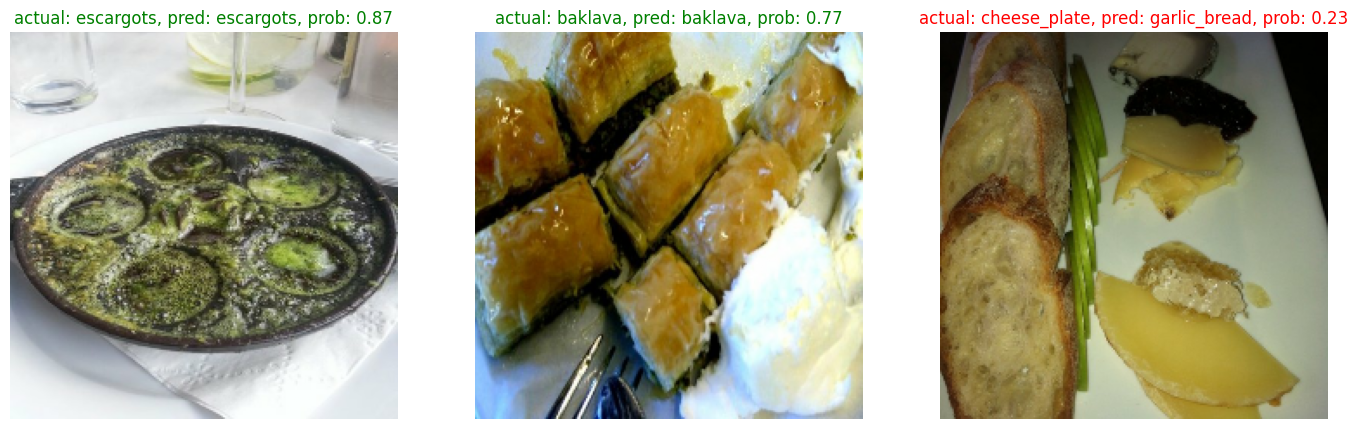

In [37]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir+ "/" + class_name))
    filepath = test_dir + class_name + "/" + filename

    # Load the images and predictions
    img = load_and_prep_image(filepath, scale=False)
    pred_prob = model.predict(tf.expand_dims(img, axis=0)) # get prediction probabilities array
    pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index

    # Plot the images
    plt.subplot(1, 3, i+1)
    plt.imshow(img/255.)
    if class_name == pred_class: # if predicted class matches truth class, make text green
        title_color = 'g'
    else:
        title_color = 'r'
    plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False);

## Finding most wrong predictions

Let's find out where our models is most wrong,
1. Get all of the image file paths in the test dataset using list_files method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes(from our model), max predictions probabilities, prediction class names, ground truth class name.
3. Use our DataFrame based on wrong predictions (where the ground truth label doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability at the top).
5. Visualize the images with the highest predictions probabilites but have the wrong prediction.

In [38]:
# Get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("Data/101_food_classes_10_percent/test/*/*.jpg",
                                    shuffle=False):
    filepaths.append(filepath.numpy())
filepaths[:10]

[b'Data\\101_food_classes_10_percent\\test\\apple_pie\\1011328.jpg',
 b'Data\\101_food_classes_10_percent\\test\\apple_pie\\101251.jpg',
 b'Data\\101_food_classes_10_percent\\test\\apple_pie\\1034399.jpg',
 b'Data\\101_food_classes_10_percent\\test\\apple_pie\\103801.jpg',
 b'Data\\101_food_classes_10_percent\\test\\apple_pie\\1038694.jpg',
 b'Data\\101_food_classes_10_percent\\test\\apple_pie\\1047447.jpg',
 b'Data\\101_food_classes_10_percent\\test\\apple_pie\\1068632.jpg',
 b'Data\\101_food_classes_10_percent\\test\\apple_pie\\110043.jpg',
 b'Data\\101_food_classes_10_percent\\test\\apple_pie\\1106961.jpg',
 b'Data\\101_food_classes_10_percent\\test\\apple_pie\\1113017.jpg']

In [39]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                       "y_true": y_labels,
                       "y_pred": pred_classes,
                       "pred_conf": preds_probs.max(axis=1), # get the maximum prediction probability value
                       "y_true_classname": [class_names[i] for i in y_labels],
                       "y_pred_classname": [class_names[i] for i in pred_classes]})

In [40]:
pred_df

img_path  y_true  y_pred  \
0      b'Data\\101_food_classes_10_percent\\test\\app...       0       2   
1      b'Data\\101_food_classes_10_percent\\test\\app...       0       0   
2      b'Data\\101_food_classes_10_percent\\test\\app...       0       0   
3      b'Data\\101_food_classes_10_percent\\test\\app...       0      38   
4      b'Data\\101_food_classes_10_percent\\test\\app...       0       8   
...                                                  ...     ...     ...   
25245  b'Data\\101_food_classes_10_percent\\test\\waf...     100     100   
25246  b'Data\\101_food_classes_10_percent\\test\\waf...     100      16   
25247  b'Data\\101_food_classes_10_percent\\test\\waf...     100      74   
25248  b'Data\\101_food_classes_10_percent\\test\\waf...     100      94   
25249  b'Data\\101_food_classes_10_percent\\test\\waf...     100      49   

       pred_conf y_true_classname         y_pred_classname  
0       0.137696        apple_pie                  baklava  
1       0.869822        apple_pie                apple_pie  
2       0.154495        apple_pie                apple_pie  
3       0.118276        apple_pie           fish_and_chips  
4       0.409920        apple_pie            bread_pudding  
...          ...              ...                      ...  
25245   0.746815          waffles                  waffles  
25246   0.791097          waffles             cheese_plate  
25247   0.211037          waffles              peking_duck  
25248   0.159750          waffles     strawberry_shortcake  
25249   0.130378          waffles  grilled_cheese_sandwich  

[25250 rows x 6 columns]

In [41]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'Data\\101_food_classes_10_percent\\test\\app...       0       2   
1  b'Data\\101_food_classes_10_percent\\test\\app...       0       0   
2  b'Data\\101_food_classes_10_percent\\test\\app...       0       0   
3  b'Data\\101_food_classes_10_percent\\test\\app...       0      38   
4  b'Data\\101_food_classes_10_percent\\test\\app...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.137696        apple_pie          baklava         False  
1   0.869822        apple_pie        apple_pie          True  
2   0.154495        apple_pie        apple_pie          True  
3   0.118276        apple_pie   fish_and_chips         False  
4   0.409920        apple_pie    bread_pudding         False

In [42]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
23797  b'Data\\101_food_classes_10_percent\\test\\sus...      95      86   
14691  b'Data\\101_food_classes_10_percent\\test\\ice...      58      79   
10346  b'Data\\101_food_classes_10_percent\\test\\fre...      41      54   
15359  b'Data\\101_food_classes_10_percent\\test\\lob...      61      53   
13943  b'Data\\101_food_classes_10_percent\\test\\hot...      55      51   
20492  b'Data\\101_food_classes_10_percent\\test\\ram...      81      75   
10847  b'Data\\101_food_classes_10_percent\\test\\fri...      43      68   
11642  b'Data\\101_food_classes_10_percent\\test\\gar...      46      10   
8794   b'Data\\101_food_classes_10_percent\\test\\esc...      35      41   
10690  b'Data\\101_food_classes_10_percent\\test\\fre...      42       6   
10277  b'Data\\101_food_classes_10_percent\\test\\fre...      41      54   
14255  b'Data\\101_food_classes_10_percent\\test\\hum...      57      49   
5849   b'Data\\101_food_classes_10_percent\\test\\chu...      23      68   
14482  b'Data\\101_food_classes_10_percent\\test\\hum...      57      51   
23300  b'Data\\101_food_classes_10_percent\\test\\ste...      93       1   
24479  b'Data\\101_food_classes_10_percent\\test\\tak...      97      78   
11146  b'Data\\101_food_classes_10_percent\\test\\fri...      44      62   
22684  b'Data\\101_food_classes_10_percent\\test\\spa...      90      91   
21652  b'Data\\101_food_classes_10_percent\\test\\sas...      86      95   
4343   b'Data\\101_food_classes_10_percent\\test\\che...      17      16   

       pred_conf       y_true_classname         y_pred_classname  pred_correct  
23797   0.972734                  sushi                  sashimi         False  
14691   0.972101              ice_cream                prime_rib         False  
10346   0.965416      french_onion_soup        hot_and_sour_soup         False  
15359   0.963681  lobster_roll_sandwich                hamburger         False  
13943   0.958160                hot_dog                guacamole         False  
20492   0.956523                  ramen                      pho         False  
10847   0.952182         fried_calamari              onion_rings         False  
11642   0.951310           garlic_bread               bruschetta         False  
8794    0.947942              escargots        french_onion_soup         False  
10690   0.947814           french_toast                 beignets         False  
10277   0.943395      french_onion_soup        hot_and_sour_soup         False  
14255   0.942558                 hummus  grilled_cheese_sandwich         False  
5849    0.940651                churros              onion_rings         False  
14482   0.938402                 hummus                guacamole         False  
23300   0.938400                  steak           baby_back_ribs         False  
24479   0.930035               takoyaki                  poutine         False  
11146   0.930012             fried_rice      macaroni_and_cheese         False  
22684   0.926120    spaghetti_bolognese      spaghetti_carbonara         False  
21652   0.926098                sashimi                    sushi         False  
4343    0.924914             cheesecake             cheese_plate         False

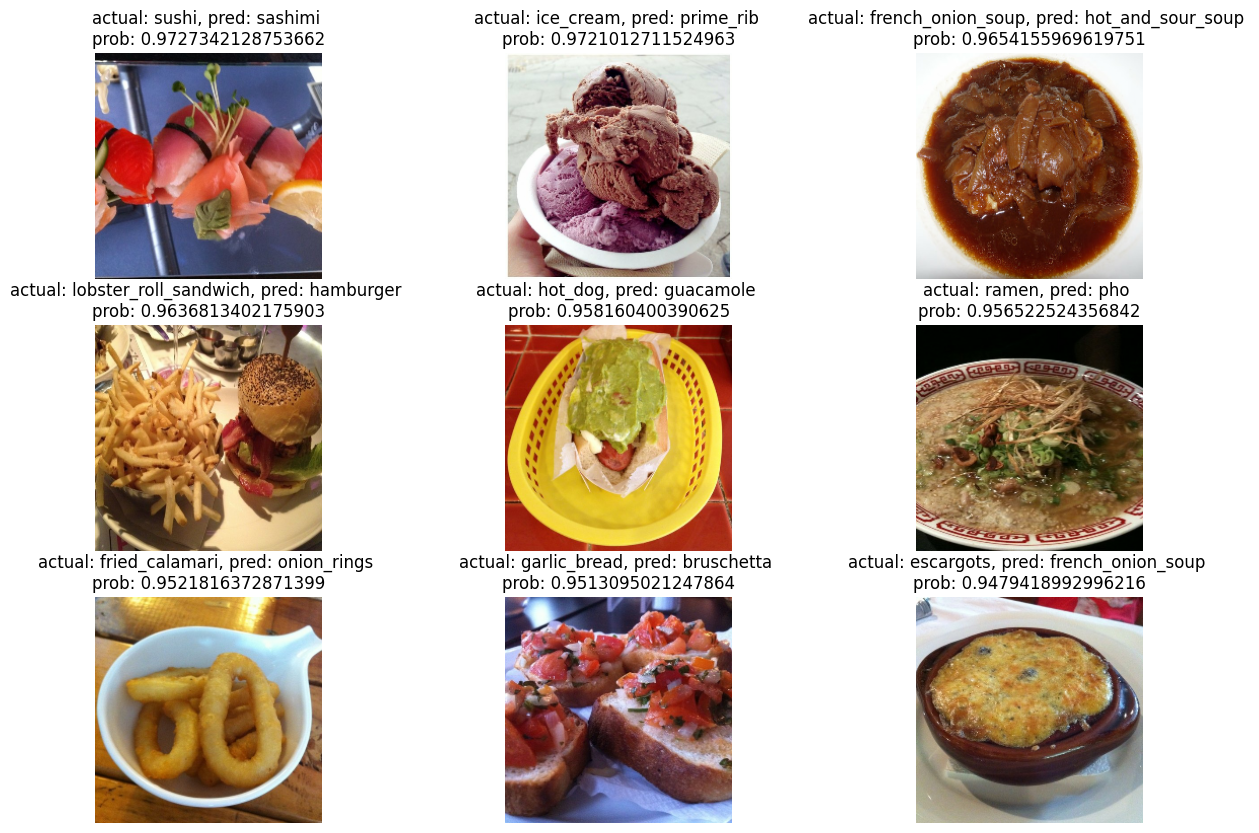

In [43]:
# 5. Visualize the test data samples which have the wrong predictions but highest pred probability
images_to_view = 9
start_index = 0
plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
    plt.subplot(3, 3, i+1)
    img = load_and_prep_image(row[1], scale=False)
    _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few paramters of each row
    plt.imshow(img/255.)
    plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname} \nprob: {pred_prob}")
    plt.axis(False)